In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import plotly
import time
import uuid
from datetime import datetime
from termcolor import colored
import optuna
import sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
SEED        = 10
folder_name = 'filtered_by_label'
limit_rows  = 1000
n_cpus      = os.cpu_count()
n_parallel  = int(n_cpus/2)
uuid        = str(uuid.uuid4())[:8]

class_names = ['Benign','DDoS','Okiru','PartOfAHorizontalPortScan']

metric_name = "log_loss" # can also be "accuracy"

error_func = {'log_loss' : sklearn.metrics.log_loss,
              'accuracy' : sklearn.metrics.accuracy_score}

directions = {'log_loss' : 'minimize',
              'accuracy' : 'maximize'}

In [3]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-03-11 01:13:25.


In [4]:
def load_csv(subset,folder=folder_name):
    if limit_rows is None:
        full_filename = f'../../Data Preprocessing/{folder}/iot23_combined_{subset}.csv'
    else:
        full_filename = f'../../Data Preprocessing/{folder}/iot23_combined_{int(limit_rows/1000)}k_{subset}.csv'
    
    df = pd.read_table(filepath_or_buffer=full_filename, header=None, sep=',').infer_objects().to_numpy()
    
    return df.ravel() if df.shape[1] == 1 else df

In [5]:
X_train, X_test, y_train, y_test = load_csv('X_train'), load_csv('X_test'), load_csv('y_train'), load_csv('y_test')

print('X_train',X_train.shape,'\ny_train',y_train.shape)
print('X_test',X_test.shape,'\ny_test',y_test.shape)

X_train (568, 16) 
y_train (568,)
X_test (143, 16) 
y_test (143,)


In [6]:
def one_hot_encode_if_necessary(data):
    if metric_name == 'log_loss':
        code_table = { 0:[1,0,0,0], 1:[0,1,0,0], 2:[0,0,1,0], 3:[0,0,0,1] }
        ans = []
        for i in range(len(data)):
            ans.append(code_table[data[i]])
    else:
        ans = data
    return ans

In [7]:
y_test = one_hot_encode_if_necessary(y_test)

In [8]:
print(f"Optimization batch started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Optimization batch started at 2022-03-11 01:13:25.


In [9]:
from catboost import CatBoostClassifier
from sklearn.kernel_approximation import AdditiveChi2Sampler, Nystroem, PolynomialCountSketch, RBFSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

best_results = {}

classifier_names = [
    'AdaBoostClassifier',
    #'CatBoostClassifier',
    'ComplementNB',
    'DecisionTreeClassifier',
    'ExtraTreesClassifier',
    'GaussianNB',
    #'GaussianProcessClassifier',
    'HistGradientBoostingClassifier',
    #'KNeighborsClassifier',
    'LinearDiscriminantAnalysis',
    'LinearSVC_AdditiveChi2Sampler',
    #'LinearSVC_Nystroem',
    #'LinearSVC_PolynomialCountSketch',
    'LinearSVC_RBFSampler',
    'MLPClassifier',
    'MultinomialNB',
    'NearestCentroid',
    'PassiveAggressiveClassifier',
    'Perceptron',
    'QuadraticDiscriminantAnalysis',
    #'RadiusNeighborsClassifier',
    'RandomForestClassifier',
    'RidgeClassifier',
    'SGDClassifier',
    'XGBClassifier'
]

for classifier_name in classifier_names:

    def objective(trial):

        if classifier_name      == 'AdaBoostClassifier':
            n_estimators         = trial.suggest_int('abc_n_estimators', 10, 200, 10)
            learning_rate        = trial.suggest_loguniform('abc_learning_rate', 1e-6, 1e0)
            classifier_obj       = AdaBoostClassifier(n_estimators=n_estimators,learning_rate=learning_rate)
            
        elif classifier_name    == 'CatBoostClassifier':
            iterations           = trial.suggest_categorical('cbc_iterations', [1000])
            learning_rate        = trial.suggest_loguniform('cbc_learning_rate', 1e-3, 1e0)
            sampling_frequency   = trial.suggest_categorical('cbc_sampling_frequency', ['PerTree', 'PerTreeLevel'])
            depth                = trial.suggest_int('cbc_depth', 2, 8, 2)
            thread_count         = trial.suggest_categorical('cbc_thread_count', [n_parallel])
            verbose              = trial.suggest_categorical('cbc_verbose', [False])
            classifier_obj       = CatBoostClassifier(iterations=iterations,
                                                      learning_rate=learning_rate,
                                                      sampling_frequency=sampling_frequency,
                                                      depth=depth,
                                                      thread_count=thread_count,
                                                      verbose=verbose)

        elif classifier_name    == 'ComplementNB':
            alpha                = trial.suggest_discrete_uniform('cnb_alpha', 0.0, 1.0, 0.05)
            fit_prior            = trial.suggest_categorical('cnb_fit_prior', [False, True])
            norm                 = trial.suggest_categorical('cnb_norm', [False, True])
            classifier_obj       = ComplementNB(alpha=alpha,fit_prior=fit_prior,norm=norm)

        elif classifier_name    == 'DecisionTreeClassifier':
            criterion            = trial.suggest_categorical('dtc_criterion', ['gini', 'entropy'])
            splitter             = trial.suggest_categorical('dtc_splitter', ['best', 'random'])
            min_samples_split    = trial.suggest_int('dtc_min_samples_split', 2, 50)
            min_samples_leaf     = trial.suggest_int('dtc_min_samples_leaf', 1, 50)
            max_features         = trial.suggest_int('dtc_max_features', 1, X_train.shape[1])
            classifier_obj       = DecisionTreeClassifier(criterion=criterion, 
                                                          splitter=splitter, 
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          max_features=max_features)

        elif classifier_name    == 'ExtraTreesClassifier':
            n_estimators         = trial.suggest_int('etc_n_estimators', 10, 200, 10)
            criterion            = trial.suggest_categorical('etc_criterion', ['gini', 'entropy'])
            min_samples_split    = trial.suggest_int('etc_min_samples_split', 2, 50)
            min_samples_leaf     = trial.suggest_int('etc_min_samples_leaf', 1, 50)
            max_features         = trial.suggest_int('etc_max_features', 1, X_train.shape[1])
            bootstrap            = trial.suggest_categorical('etc_bootstrap', [False, True])
            n_jobs               = trial.suggest_categorical('etc_n_jobs', [n_parallel])
            classifier_obj       = ExtraTreesClassifier(n_estimators=n_estimators,
                                                        criterion=criterion, 
                                                        min_samples_split=min_samples_split,
                                                        min_samples_leaf=min_samples_leaf,
                                                        max_features=max_features,
                                                        bootstrap=bootstrap,
                                                        n_jobs=n_jobs)

        elif classifier_name    == 'GaussianNB':
            var_smoothing        = trial.suggest_loguniform('gnb_var_smoothing', 1e-12, 1e3)
            classifier_obj       = GaussianNB(var_smoothing=var_smoothing)

        elif classifier_name    == 'GaussianProcessClassifier':
            max_iter_predict     = trial.suggest_int('gpc_max_iter_predict', 50, 200, 50)
            multi_class          = trial.suggest_categorical('gpc_multi_class', ['one_vs_one', 'one_vs_rest'])
            classifier_obj       = GaussianProcessClassifier(max_iter_predict=max_iter_predict,
                                                             multi_class=multi_class)
        
        elif classifier_name    == 'HistGradientBoostingClassifier':
            learning_rate        = trial.suggest_loguniform('hgbc_learning_rate', 1e-3, 1e0)
            max_iter             = trial.suggest_categorical('hgbc_max_iter', [1000])
            min_samples_leaf     = trial.suggest_int('hgbc_min_samples_leaf', 1, 50)
            l2_regularization    = trial.suggest_discrete_uniform('hgbc_l2_regularization', 0.0, 1.0, 0.2)
            max_bins             = trial.suggest_categorical('hgbc_max_bins', [63, 127, 255])
            early_stopping       = trial.suggest_categorical('hgbc_early_stopping', [True])
            validation_fraction  = trial.suggest_categorical('hgbc_validation_fraction', [0.25])
            n_iter_no_change     = trial.suggest_categorical('hgbc_n_iter_no_change', [10])
            classifier_obj       = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                                                 max_iter=max_iter,
                                                                 min_samples_leaf=min_samples_leaf,
                                                                 l2_regularization=l2_regularization,
                                                                 max_bins=max_bins,
                                                                 early_stopping=early_stopping,
                                                                 validation_fraction=validation_fraction,
                                                                 n_iter_no_change=n_iter_no_change)
        
        elif classifier_name    == 'KNeighborsClassifier':
            n_neighbors          = trial.suggest_int('knc_n_neighbors', 1, 15, 2)
            leaf_size            = trial.suggest_int('knc_leaf_size', 10, 100, 10)
            n_jobs               = trial.suggest_categorical('knc_n_jobs', [n_parallel])
            classifier_obj       = KNeighborsClassifier(n_neighbors=n_neighbors,leaf_size=leaf_size,n_jobs=n_jobs)

        elif classifier_name    == 'LinearDiscriminantAnalysis':
            solver               = trial.suggest_categorical('lda_solver', ['svd', 'lsqr', 'eigen'])
            shrinkage            = None if solver == 'svd' else trial.suggest_categorical('lda_shrinkage', ['auto'])
            n_features,n_classes = X_train.shape[1],len(set(y_train))
            n_components         = trial.suggest_int('lda_n_components', 1, min(n_features, n_classes-1), 1)
            tol                  = 1e-4 if solver == 'svd' else trial.suggest_categorical('lda_tol', [1e-5, 1e-4, 1e-3])
            classifier_obj       = LinearDiscriminantAnalysis(solver=solver,shrinkage=shrinkage,n_components=n_components,tol=tol)

        elif classifier_name    == 'LinearSVC_AdditiveChi2Sampler':
            kernel_sample_steps  = trial.suggest_categorical('lsvc_ac2s_kernel_sample_steps', [1, 2, 3])
            dual                 = trial.suggest_categorical('lsvc_ac2s_dual', [False])
            C                    = trial.suggest_loguniform('lsvc_ac2s_C', 1e-6, 1e3)
            max_iter             = trial.suggest_categorical('lsvc_ac2s_max_iter', [1000])
            classifier_obj       = LinearSVC(dual=dual,C=C,max_iter=max_iter)
        
        elif classifier_name    == 'LinearSVC_Nystroem':
            kernel_gamma         = trial.suggest_loguniform('lsvc_nystroem_kernel_gamma', 1e-3, 1e3)
            kernel_n_components  = trial.suggest_int('lsvc_nystroem_kernel_n_components', 50, 150, 50)
            dual                 = trial.suggest_categorical('lsvc_nystroem_dual', [False])
            C                    = trial.suggest_loguniform('lsvc_nystroem_C', 1e-6, 1e3)
            max_iter             = trial.suggest_categorical('lsvc_nystroem_max_iter', [1000])
            classifier_obj       = LinearSVC(dual=dual,C=C,max_iter=max_iter)
        
        elif classifier_name    == 'LinearSVC_PolynomialCountSketch':
            kernel_gamma         = trial.suggest_loguniform('lsvc_pcs_kernel_gamma', 1e-3, 1e3)
            kernel_n_components  = trial.suggest_int('lsvc_pcs_kernel_n_components', 50, 150, 50)
            kernel_degree        = trial.suggest_categorical('lsvc_pcs_degree', [2])
            dual                 = trial.suggest_categorical('lsvc_pcs_dual', [False])
            C                    = trial.suggest_loguniform('lsvc_pcs_C', 1e-6, 1e3)
            max_iter             = trial.suggest_categorical('lsvc_pcs,max_iter', [1000])
            classifier_obj       = LinearSVC(dual=dual,C=C,max_iter=max_iter)
        
        elif classifier_name    == 'LinearSVC_RBFSampler':
            kernel_gamma         = trial.suggest_loguniform('lsvc_rbfs_kernel_gamma', 1e-3, 1e3)
            kernel_n_components  = trial.suggest_int('lsvc_rbfs_kernel_n_components', 50, 150, 50)
            dual                 = trial.suggest_categorical('lsvc_rbfs_dual', [False])
            C                    = trial.suggest_loguniform('lsvc_rbfs_C', 1e-6, 1e3)
            max_iter             = trial.suggest_categorical('lsvc_rbfs,max_iter', [1000])
            classifier_obj       = LinearSVC(dual=dual,C=C,max_iter=max_iter)

        elif classifier_name    == 'MLPClassifier':
            create_hidden_layers = lambda value,count : tuple([int(value*2**(count-i-1)) for i in range(0,count)])
            hidden_layer_count   = trial.suggest_int('mlpc_hidden_layer_count', 1, 3, 1)
            hidden_layer_sizes   = create_hidden_layers(2*X_train.shape[1], hidden_layer_count)
            learning_rate        = trial.suggest_categorical('mlpc_learning_rate', ['constant', 'invscaling', 'adaptive'])
            learning_rate_init   = trial.suggest_loguniform('mlpc_learning_rate_init', 1e-6, 1e0)
            max_iter             = trial.suggest_categorical('mplc_max_iter', [2000])
            classifier_obj       = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                                 learning_rate=learning_rate,
                                                 learning_rate_init=learning_rate_init,
                                                 max_iter=max_iter)

        elif classifier_name    == 'MultinomialNB':
            alpha                = trial.suggest_discrete_uniform('mnb_alpha', 0.0, 1.0, 0.05)
            fit_prior            = trial.suggest_categorical('mnb_fit_prior', [False, True])
            classifier_obj       = MultinomialNB(alpha=alpha,fit_prior=fit_prior)
            
        elif classifier_name    == 'NearestCentroid':
            metric               = trial.suggest_categorical('nc_metric', ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'])
            shrink_threshold     = trial.suggest_categorical('nc_shrink_threshold', [None, 0.2])
            classifier_obj       = NearestCentroid(metric=metric,shrink_threshold=shrink_threshold)

        elif classifier_name    == 'PassiveAggressiveClassifier':
            C                    = trial.suggest_loguniform('pac_C', 1e-6, 1e3)
            early_stopping       = trial.suggest_categorical('pac_early_stopping', [True])
            validation_fraction  = trial.suggest_categorical('pac_validation_fraction', [0.25])
            n_iter_no_change     = trial.suggest_categorical('pac_n_iter_no_change', [10])
            n_jobs               = trial.suggest_categorical('pac_n_jobs', [n_parallel])
            classifier_obj       = PassiveAggressiveClassifier(C=C,
                                                               early_stopping=early_stopping,
                                                               validation_fraction=validation_fraction,
                                                               n_iter_no_change=n_iter_no_change,
                                                               n_jobs=n_jobs)

        elif classifier_name    == 'Perceptron':
            penalty              = trial.suggest_categorical('p_penalty', ['elasticnet'])
            alpha                = trial.suggest_loguniform('p_alpha', 1e-6, 1e0)
            eta0                 = trial.suggest_discrete_uniform('p_eta0', 0.5, 2.0, 0.5)
            n_jobs               = trial.suggest_categorical('p_n_jobs', [n_parallel])
            early_stopping       = trial.suggest_categorical('p_early_stopping', [True])
            validation_fraction  = trial.suggest_categorical('p_validation_fraction', [0.25])
            n_iter_no_change     = trial.suggest_categorical('p_n_iter_no_change', [10])
            classifier_obj       = Perceptron(penalty=penalty,
                                              alpha=alpha,
                                              eta0=eta0,
                                              n_jobs=n_jobs,
                                              early_stopping=early_stopping,
                                              n_iter_no_change=n_iter_no_change)

        elif classifier_name    == 'QuadraticDiscriminantAnalysis':
            reg_param            = trial.suggest_discrete_uniform('qda_reg_param', 0.0, 1.0, 0.05)
            tol                  = trial.suggest_loguniform('qda_tol', 1e-6, 1e-3)
            classifier_obj       = QuadraticDiscriminantAnalysis(reg_param=reg_param,tol=tol)

        elif classifier_name    == 'RadiusNeighborsClassifier':
            radius               = trial.suggest_categorical('rnc_radius', [0.5, 1.0, 2.0])
            weights              = trial.suggest_categorical('rnc_weights', ['uniform', 'distance'])
            n_jobs               = trial.suggest_categorical('rnc_n_jobs', [n_parallel])
            classifier_obj       = RadiusNeighborsClassifier(radius=radius,weights=weights,n_jobs=n_jobs)

        elif classifier_name    == 'RandomForestClassifier':
            n_estimators         = trial.suggest_int('rfc_n_estimators', 10, 200, 10)
            criterion            = trial.suggest_categorical('criterion', ['gini', 'entropy'])
            min_samples_split    = trial.suggest_int('rfc_min_samples_split', 2, 50)
            min_samples_leaf     = trial.suggest_int('rfc_min_samples_leaf', 1, 50)
            max_features         = trial.suggest_int('rfc_max_features', 1, X_train.shape[1])
            bootstrap            = trial.suggest_categorical('rfc_bootstrap', [False, True])
            n_jobs               = trial.suggest_categorical('rfc_n_jobs', [n_parallel])
            classifier_obj       = RandomForestClassifier(n_estimators=n_estimators,
                                                          criterion=criterion, 
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          max_features=max_features,
                                                          bootstrap=bootstrap,
                                                          n_jobs=n_jobs)
                                                          
        elif classifier_name    == 'RidgeClassifier':
            alpha                = trial.suggest_loguniform('rc_C', 1e-6, 1e6)
            tol                  = trial.suggest_loguniform('rc_tol', 1e-4, 1e-2)
            classifier_obj       = RidgeClassifier(alpha=alpha,tol=tol)
        
        elif classifier_name    == 'SGDClassifier':
            loss                 = trial.suggest_categorical('sgdc_loss', ['hinge', 'log', 'modified_huber', 'squared_hinge'])
            penalty              = trial.suggest_categorical('sgdc_penalty', ['elasticnet'])
            alpha                = trial.suggest_loguniform('sgdc_alpha', 1e-6, 1e3)
            l1_ratio             = trial.suggest_discrete_uniform('sgdc_l1_ratio', 0.0, 1.0, 0.2)
            n_jobs               = trial.suggest_categorical('sgdc_n_jobs', [n_parallel])
            learning_rate        = trial.suggest_categorical('sgdc_learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
            eta0                 = trial.suggest_loguniform('sgdc_eta0', 1e-3, 1e3)
            early_stopping       = trial.suggest_categorical('sgdc_early_stopping', [True])
            validation_fraction  = trial.suggest_categorical('sgdc_validation_fraction', [0.25])
            n_iter_no_change     = trial.suggest_categorical('sgdc_n_iter_no_change', [10])
            classifier_obj       = SGDClassifier(loss=loss,
                                                 penalty=penalty,
                                                 alpha=alpha,
                                                 l1_ratio=l1_ratio,
                                                 n_jobs=n_jobs,
                                                 learning_rate=learning_rate,
                                                 eta0=eta0,
                                                 early_stopping=early_stopping,
                                                 validation_fraction=validation_fraction,
                                                 n_iter_no_change=n_iter_no_change)
            
        else: # classifier_name == 'XGBClassifier'
            n_estimators         = trial.suggest_int('xgbc_n_estimators', 10, 200, 10)
            use_label_encoder    = trial.suggest_categorical('xgbc_use_label_encoder', [False])
            learning_rate        = trial.suggest_loguniform('xgbc_learning_rate', 1e-6, 1e0)
            booster              = trial.suggest_categorical('xgbc_booster', ['gbtree', 'gblinear', 'dart'])
            n_jobs               = trial.suggest_categorical('xgbc_n_jobs', [n_parallel])
            gamma                = trial.suggest_loguniform('xgbc_gamma', 1e-6, 1e0)
            classifier_obj       = XGBClassifier(n_estimators=n_estimators, 
                                                 use_label_encoder=use_label_encoder,
                                                 learning_rate=learning_rate,
                                                 booster=booster,
                                                 gamma=gamma,
                                                 n_jobs=n_jobs)
        
        # fit, predict and evaluate
        
        if classifier_name == 'LinearSVC_AdditiveChi2Sampler':
            feature_mapper = AdditiveChi2Sampler(sample_steps=kernel_sample_steps).fit(X_train)
            classifier_obj.fit(feature_mapper.transform(X_train), y_train)
            y_pred = classifier_obj.predict(feature_mapper.transform(X_test))
        elif classifier_name == 'LinearSVC_Nystroem':
            feature_mapper = Nystroem(gamma=kernel_gamma,n_components=kernel_n_components).fit(X_train)
            classifier_obj.fit(feature_mapper.transform(X_train), y_train)
            y_pred = classifier_obj.predict(feature_mapper.transform(X_test))
        elif classifier_name == 'LinearSVC_PolynomialCountSketch':
            feature_mapper = PolynomialCountSketch(gamma=kernel_gamma,n_components=kernel_n_components,degree=kernel_degree).fit(X_train)
            classifier_obj.fit(feature_mapper.transform(X_train), y_train)
            y_pred = classifier_obj.predict(feature_mapper.transform(X_test))
        elif classifier_name == 'LinearSVC_RBFSampler':
            feature_mapper = RBFSampler(gamma=kernel_gamma,n_components=kernel_n_components).fit(X_train)
            classifier_obj.fit(feature_mapper.transform(X_train), y_train)
            y_pred = classifier_obj.predict(feature_mapper.transform(X_test))
        else:
            classifier_obj.fit(X_train, y_train)
            y_pred = classifier_obj.predict(X_test)
            
        y_pred = one_hot_encode_if_necessary(y_pred)
                
        report = classification_report(y_test, y_pred, output_dict=True, target_names=class_names, zero_division=0)
        
        trial.set_user_attr('report', report)
        
        return error_func[metric_name](y_test, y_pred)
    
    study = optuna.create_study(direction=directions[metric_name])

    print(f'--------------------------------------------------------------------------------')
    print(f'-------------------- {classifier_name.center(38)} --------------------')
    print(f'--------------------------------------------------------------------------------')
        
    print(f"Study optimization started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")
    #study.optimize(objective, timeout=60*60, n_trials=100, n_jobs=1, catch=(ValueError,), gc_after_trial=True)
    study.optimize(objective, timeout=60, n_trials=10, n_jobs=1, catch=(ValueError,), gc_after_trial=True)
    print(f"Study optimization finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")
    
    #optuna.visualization.plot_optimization_history(study).show()
    
    if classifier_name not in best_results.keys():
        best_results[classifier_name] = []
    
    for trial in study.get_trials():
        try:
            best_results[classifier_name].append({
                'id'     : trial.number, 
                'loss'   : trial.values[0], 
                'params' : trial.params,
                'report' : trial.user_attrs['report']
            })
        except:
            best_results[classifier_name] = [{'id':-1, 'loss':0.0, 'params':[], 'report':{}}]

C:\Users\marce\anaconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[I 2022-03-11 01:13:25,914] A new study created in memory with name: no-name-3e90c0f4-4de0-4338-a167-30c1203f3218


--------------------------------------------------------------------------------
--------------------           AdaBoostClassifier           --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:13:25.


[I 2022-03-11 01:13:26,062] Trial 0 finished with value: 6.279777526347398 and parameters: {'abc_n_estimators': 100, 'abc_learning_rate': 0.0008807701207447168}. Best is trial 0 with value: 6.279777526347398.
[I 2022-03-11 01:13:26,254] Trial 1 finished with value: 8.212016765223519 and parameters: {'abc_n_estimators': 130, 'abc_learning_rate': 4.4281689646814e-05}. Best is trial 0 with value: 6.279777526347398.
[I 2022-03-11 01:13:26,476] Trial 2 finished with value: 5.072128002049821 and parameters: {'abc_n_estimators': 160, 'abc_learning_rate': 0.013554446444181998}. Best is trial 2 with value: 5.072128002049821.
[I 2022-03-11 01:13:26,599] Trial 3 finished with value: 8.212016765223519 and parameters: {'abc_n_estimators': 60, 'abc_learning_rate': 8.977127374931101e-05}. Best is trial 2 with value: 5.072128002049821.
[I 2022-03-11 01:13:26,775] Trial 4 finished with value: 6.279777526347398 and parameters: {'abc_n_estimators': 120, 'abc_learning_rate': 0.00025981423720408176}. Best 

Study optimization finished at 2022-03-11 01:13:27.
--------------------------------------------------------------------------------
--------------------              ComplementNB              --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:13:27.


[I 2022-03-11 01:13:28,001] Trial 3 finished with value: 5.313657906909336 and parameters: {'cnb_alpha': 0.8500000000000001, 'cnb_fit_prior': True, 'cnb_norm': False}. Best is trial 2 with value: 5.313657906909336.
[I 2022-03-11 01:13:28,065] Trial 4 finished with value: 5.313657906909336 and parameters: {'cnb_alpha': 0.25, 'cnb_fit_prior': False, 'cnb_norm': False}. Best is trial 2 with value: 5.313657906909336.
[I 2022-03-11 01:13:28,130] Trial 5 finished with value: 5.313657906909336 and parameters: {'cnb_alpha': 0.5, 'cnb_fit_prior': False, 'cnb_norm': False}. Best is trial 2 with value: 5.313657906909336.
[I 2022-03-11 01:13:28,197] Trial 6 finished with value: 5.313657906909336 and parameters: {'cnb_alpha': 0.35000000000000003, 'cnb_fit_prior': False, 'cnb_norm': False}. Best is trial 2 with value: 5.313657906909336.
[I 2022-03-11 01:13:28,268] Trial 7 finished with value: 5.555187811768851 and parameters: {'cnb_alpha': 0.6000000000000001, 'cnb_fit_prior': False, 'cnb_norm': True

Study optimization finished at 2022-03-11 01:13:28.
--------------------------------------------------------------------------------
--------------------         DecisionTreeClassifier         --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:13:28.


[I 2022-03-11 01:13:28,673] Trial 3 finished with value: 4.347538287471276 and parameters: {'dtc_criterion': 'gini', 'dtc_splitter': 'best', 'dtc_min_samples_split': 12, 'dtc_min_samples_leaf': 42, 'dtc_max_features': 14}. Best is trial 2 with value: 1.449179429157094.
[I 2022-03-11 01:13:28,743] Trial 4 finished with value: 0.9661196194380635 and parameters: {'dtc_criterion': 'entropy', 'dtc_splitter': 'best', 'dtc_min_samples_split': 17, 'dtc_min_samples_leaf': 19, 'dtc_max_features': 10}. Best is trial 4 with value: 0.9661196194380635.
[I 2022-03-11 01:13:28,812] Trial 5 finished with value: 4.347538287471276 and parameters: {'dtc_criterion': 'entropy', 'dtc_splitter': 'best', 'dtc_min_samples_split': 46, 'dtc_min_samples_leaf': 46, 'dtc_max_features': 15}. Best is trial 4 with value: 0.9661196194380635.
[I 2022-03-11 01:13:28,881] Trial 6 finished with value: 7.970486860364004 and parameters: {'dtc_criterion': 'gini', 'dtc_splitter': 'best', 'dtc_min_samples_split': 30, 'dtc_min_sa

Study optimization finished at 2022-03-11 01:13:29.
--------------------------------------------------------------------------------
--------------------          ExtraTreesClassifier          --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:13:29.


[I 2022-03-11 01:13:29,539] Trial 2 finished with value: 0.7245897145785484 and parameters: {'etc_n_estimators': 150, 'etc_criterion': 'gini', 'etc_min_samples_split': 22, 'etc_min_samples_leaf': 10, 'etc_max_features': 14, 'etc_bootstrap': True, 'etc_n_jobs': 8}. Best is trial 1 with value: 0.7245897145785484.
[I 2022-03-11 01:13:29,784] Trial 3 finished with value: 1.9322392388761243 and parameters: {'etc_n_estimators': 160, 'etc_criterion': 'gini', 'etc_min_samples_split': 19, 'etc_min_samples_leaf': 31, 'etc_max_features': 11, 'etc_bootstrap': False, 'etc_n_jobs': 8}. Best is trial 1 with value: 0.7245897145785484.
[I 2022-03-11 01:13:30,067] Trial 4 finished with value: 6.279777526347398 and parameters: {'etc_n_estimators': 140, 'etc_criterion': 'entropy', 'etc_min_samples_split': 16, 'etc_min_samples_leaf': 31, 'etc_max_features': 9, 'etc_bootstrap': True, 'etc_n_jobs': 8}. Best is trial 1 with value: 0.7245897145785484.
[I 2022-03-11 01:13:30,227] Trial 5 finished with value: 1.

Study optimization finished at 2022-03-11 01:13:30.
--------------------------------------------------------------------------------
--------------------               GaussianNB               --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:13:30.


[I 2022-03-11 01:13:31,161] Trial 3 finished with value: 5.555187811768851 and parameters: {'gnb_var_smoothing': 1.482735370721972e-11}. Best is trial 0 with value: 5.313657906909336.
[I 2022-03-11 01:13:31,244] Trial 4 finished with value: 6.279777526347398 and parameters: {'gnb_var_smoothing': 6.183738218714873}. Best is trial 0 with value: 5.313657906909336.
[I 2022-03-11 01:13:31,329] Trial 5 finished with value: 5.313657906909336 and parameters: {'gnb_var_smoothing': 3.2341451981293346e-10}. Best is trial 0 with value: 5.313657906909336.
[I 2022-03-11 01:13:31,411] Trial 6 finished with value: 6.521307431206913 and parameters: {'gnb_var_smoothing': 4.281400666633523e-12}. Best is trial 0 with value: 5.313657906909336.
[I 2022-03-11 01:13:31,492] Trial 7 finished with value: 5.313657906909336 and parameters: {'gnb_var_smoothing': 0.000506000431078267}. Best is trial 0 with value: 5.313657906909336.
[I 2022-03-11 01:13:31,576] Trial 8 finished with value: 14.733324196430429 and para

Study optimization finished at 2022-03-11 01:13:31.
--------------------------------------------------------------------------------
--------------------     HistGradientBoostingClassifier     --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:13:31.


[I 2022-03-11 01:13:36,410] Trial 0 finished with value: 0.7245897145785484 and parameters: {'hgbc_learning_rate': 0.006274062951042754, 'hgbc_max_iter': 1000, 'hgbc_min_samples_leaf': 30, 'hgbc_l2_regularization': 0.0, 'hgbc_max_bins': 63, 'hgbc_early_stopping': True, 'hgbc_validation_fraction': 0.25, 'hgbc_n_iter_no_change': 10}. Best is trial 0 with value: 0.7245897145785484.
[I 2022-03-11 01:13:43,523] Trial 1 finished with value: 0.7245897145785484 and parameters: {'hgbc_learning_rate': 0.0034711891390715936, 'hgbc_max_iter': 1000, 'hgbc_min_samples_leaf': 15, 'hgbc_l2_regularization': 1.0, 'hgbc_max_bins': 63, 'hgbc_early_stopping': True, 'hgbc_validation_fraction': 0.25, 'hgbc_n_iter_no_change': 10}. Best is trial 0 with value: 0.7245897145785484.
[I 2022-03-11 01:13:46,538] Trial 2 finished with value: 0.7245897145785484 and parameters: {'hgbc_learning_rate': 0.03097614802571277, 'hgbc_max_iter': 1000, 'hgbc_min_samples_leaf': 33, 'hgbc_l2_regularization': 0.8, 'hgbc_max_bins':

Study optimization finished at 2022-03-11 01:13:59.
--------------------------------------------------------------------------------
--------------------       LinearDiscriminantAnalysis       --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:13:59.


[I 2022-03-11 01:14:00,165] Trial 3 finished with value: 6.521307431206913 and parameters: {'lda_solver': 'svd', 'lda_n_components': 1}. Best is trial 0 with value: 6.521307431206913.
[I 2022-03-11 01:14:00,250] Trial 4 finished with value: 6.521307431206913 and parameters: {'lda_solver': 'svd', 'lda_n_components': 1}. Best is trial 0 with value: 6.521307431206913.
[I 2022-03-11 01:14:00,335] Trial 5 finished with value: 6.521307431206913 and parameters: {'lda_solver': 'lsqr', 'lda_shrinkage': 'auto', 'lda_n_components': 3, 'lda_tol': 0.0001}. Best is trial 0 with value: 6.521307431206913.
[I 2022-03-11 01:14:00,416] Trial 6 finished with value: 6.521307431206913 and parameters: {'lda_solver': 'eigen', 'lda_shrinkage': 'auto', 'lda_n_components': 2, 'lda_tol': 0.001}. Best is trial 0 with value: 6.521307431206913.
[I 2022-03-11 01:14:00,500] Trial 7 finished with value: 6.521307431206913 and parameters: {'lda_solver': 'svd', 'lda_n_components': 2}. Best is trial 0 with value: 6.5213074

Study optimization finished at 2022-03-11 01:14:00.
--------------------------------------------------------------------------------
--------------------     LinearSVC_AdditiveChi2Sampler      --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:00.


[I 2022-03-11 01:14:00,966] Trial 3 finished with value: 14.733324196430429 and parameters: {'lsvc_ac2s_kernel_sample_steps': 2, 'lsvc_ac2s_dual': False, 'lsvc_ac2s_C': 0.0001328843925518538, 'lsvc_ac2s_max_iter': 1000}. Best is trial 0 with value: 6.279777526347398.
[I 2022-03-11 01:14:01,042] Trial 4 finished with value: 14.733324196430429 and parameters: {'lsvc_ac2s_kernel_sample_steps': 2, 'lsvc_ac2s_dual': False, 'lsvc_ac2s_C': 9.357647387120442e-06, 'lsvc_ac2s_max_iter': 1000}. Best is trial 0 with value: 6.279777526347398.
[I 2022-03-11 01:14:01,118] Trial 5 finished with value: 14.733324196430429 and parameters: {'lsvc_ac2s_kernel_sample_steps': 1, 'lsvc_ac2s_dual': False, 'lsvc_ac2s_C': 2.8411923021591342e-05, 'lsvc_ac2s_max_iter': 1000}. Best is trial 0 with value: 6.279777526347398.
[I 2022-03-11 01:14:01,198] Trial 6 finished with value: 5.313657906909336 and parameters: {'lsvc_ac2s_kernel_sample_steps': 1, 'lsvc_ac2s_dual': False, 'lsvc_ac2s_C': 102.1669934033924, 'lsvc_ac

Study optimization finished at 2022-03-11 01:14:01.
--------------------------------------------------------------------------------
--------------------          LinearSVC_RBFSampler          --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:01.


[I 2022-03-11 01:14:01,800] Trial 3 finished with value: 14.733324196430429 and parameters: {'lsvc_rbfs_kernel_gamma': 0.003591039716502552, 'lsvc_rbfs_kernel_n_components': 150, 'lsvc_rbfs_dual': False, 'lsvc_rbfs_C': 0.0015697959114256246, 'lsvc_rbfs,max_iter': 1000}. Best is trial 2 with value: 5.072128002049821.
[I 2022-03-11 01:14:01,882] Trial 4 finished with value: 6.279777526347398 and parameters: {'lsvc_rbfs_kernel_gamma': 0.01788261968544132, 'lsvc_rbfs_kernel_n_components': 150, 'lsvc_rbfs_dual': False, 'lsvc_rbfs_C': 0.044502453345656626, 'lsvc_rbfs,max_iter': 1000}. Best is trial 2 with value: 5.072128002049821.
[I 2022-03-11 01:14:01,976] Trial 5 finished with value: 5.072128002049821 and parameters: {'lsvc_rbfs_kernel_gamma': 0.34857801546988393, 'lsvc_rbfs_kernel_n_components': 150, 'lsvc_rbfs_dual': False, 'lsvc_rbfs_C': 0.03938935671081744, 'lsvc_rbfs,max_iter': 1000}. Best is trial 2 with value: 5.072128002049821.
[I 2022-03-11 01:14:02,057] Trial 6 finished with val

Study optimization finished at 2022-03-11 01:14:02.
--------------------------------------------------------------------------------
--------------------             MLPClassifier              --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:02.


[I 2022-03-11 01:14:03,125] Trial 0 finished with value: 5.072128002049821 and parameters: {'mlpc_hidden_layer_count': 1, 'mlpc_learning_rate': 'invscaling', 'mlpc_learning_rate_init': 0.00024653296656126553, 'mplc_max_iter': 2000}. Best is trial 0 with value: 5.072128002049821.
[I 2022-03-11 01:14:03,735] Trial 1 finished with value: 5.072128002049821 and parameters: {'mlpc_hidden_layer_count': 1, 'mlpc_learning_rate': 'adaptive', 'mlpc_learning_rate_init': 0.00034112938191415494, 'mplc_max_iter': 2000}. Best is trial 0 with value: 5.072128002049821.
[I 2022-03-11 01:14:08,234] Trial 2 finished with value: 5.072128002049821 and parameters: {'mlpc_hidden_layer_count': 3, 'mlpc_learning_rate': 'adaptive', 'mlpc_learning_rate_init': 2.9450526911215012e-05, 'mplc_max_iter': 2000}. Best is trial 0 with value: 5.072128002049821.
[I 2022-03-11 01:14:08,477] Trial 3 finished with value: 5.072128002049821 and parameters: {'mlpc_hidden_layer_count': 1, 'mlpc_learning_rate': 'adaptive', 'mlpc_le

Study optimization finished at 2022-03-11 01:14:20.
--------------------------------------------------------------------------------
--------------------             MultinomialNB              --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:20.


[I 2022-03-11 01:14:20,867] Trial 3 finished with value: 6.279777526347399 and parameters: {'mnb_alpha': 0.6000000000000001, 'mnb_fit_prior': False}. Best is trial 0 with value: 5.555187811768851.
[I 2022-03-11 01:14:20,936] Trial 4 finished with value: 5.313657906909336 and parameters: {'mnb_alpha': 0.15000000000000002, 'mnb_fit_prior': True}. Best is trial 4 with value: 5.313657906909336.
[I 2022-03-11 01:14:21,003] Trial 5 finished with value: 5.555187811768851 and parameters: {'mnb_alpha': 0.05, 'mnb_fit_prior': True}. Best is trial 4 with value: 5.313657906909336.
[I 2022-03-11 01:14:21,067] Trial 6 finished with value: 6.279777526347399 and parameters: {'mnb_alpha': 0.9, 'mnb_fit_prior': False}. Best is trial 4 with value: 5.313657906909336.
C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
[I 2022-03-11 01:14:21,133] Trial 7 finished with value: 5.313

Study optimization finished at 2022-03-11 01:14:21.
--------------------------------------------------------------------------------
--------------------            NearestCentroid             --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:21.


[I 2022-03-11 01:14:21,556] Trial 3 finished with value: 7.004367240925943 and parameters: {'nc_metric': 'euclidean', 'nc_shrink_threshold': None}. Best is trial 1 with value: 7.004367240925943.
C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
[I 2022-03-11 01:14:21,625] Trial 4 finished with value: 11.110375623537703 and parameters: {'nc_metric': 'l1', 'nc_shrink_threshold': None}. Best is trial 1 with value: 7.004367240925943.
[I 2022-03-11 01:14:21,693] Trial 5 finished with value: 10.385785908959157 and parameters: {'nc_metric': 'manhattan', 'nc_shrink_threshold': None}. Best is trial 1 with value: 7.004367240925943.
C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The aver

Study optimization finished at 2022-03-11 01:14:22.
--------------------------------------------------------------------------------
--------------------      PassiveAggressiveClassifier       --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:22.


[I 2022-03-11 01:14:22,241] Trial 2 finished with value: 6.279777526347398 and parameters: {'pac_C': 0.00026535231695781444, 'pac_early_stopping': True, 'pac_validation_fraction': 0.25, 'pac_n_iter_no_change': 10, 'pac_n_jobs': 8}. Best is trial 2 with value: 6.279777526347398.
[I 2022-03-11 01:14:22,339] Trial 3 finished with value: 6.762837336066427 and parameters: {'pac_C': 0.00040263868203986645, 'pac_early_stopping': True, 'pac_validation_fraction': 0.25, 'pac_n_iter_no_change': 10, 'pac_n_jobs': 8}. Best is trial 2 with value: 6.279777526347398.
[I 2022-03-11 01:14:22,431] Trial 4 finished with value: 5.072128002049821 and parameters: {'pac_C': 0.013595084935967889, 'pac_early_stopping': True, 'pac_validation_fraction': 0.25, 'pac_n_iter_no_change': 10, 'pac_n_jobs': 8}. Best is trial 4 with value: 5.072128002049821.
[I 2022-03-11 01:14:22,523] Trial 5 finished with value: 5.313657906909336 and parameters: {'pac_C': 438.23194905170755, 'pac_early_stopping': True, 'pac_validation_

Study optimization finished at 2022-03-11 01:14:22.
--------------------------------------------------------------------------------
--------------------               Perceptron               --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:22.


[I 2022-03-11 01:14:23,172] Trial 2 finished with value: 5.072128002049821 and parameters: {'p_penalty': 'elasticnet', 'p_alpha': 1.260658478916186e-05, 'p_eta0': 1.5, 'p_n_jobs': 8, 'p_early_stopping': True, 'p_validation_fraction': 0.25, 'p_n_iter_no_change': 10}. Best is trial 1 with value: 5.072128002049821.
[I 2022-03-11 01:14:23,266] Trial 3 finished with value: 5.072128002049821 and parameters: {'p_penalty': 'elasticnet', 'p_alpha': 5.4587625218463066e-05, 'p_eta0': 1.0, 'p_n_jobs': 8, 'p_early_stopping': True, 'p_validation_fraction': 0.25, 'p_n_iter_no_change': 10}. Best is trial 1 with value: 5.072128002049821.
[I 2022-03-11 01:14:23,359] Trial 4 finished with value: 5.072128002049821 and parameters: {'p_penalty': 'elasticnet', 'p_alpha': 0.00019323403197381842, 'p_eta0': 1.5, 'p_n_jobs': 8, 'p_early_stopping': True, 'p_validation_fraction': 0.25, 'p_n_iter_no_change': 10}. Best is trial 1 with value: 5.072128002049821.
[I 2022-03-11 01:14:23,449] Trial 5 finished with value:

Study optimization finished at 2022-03-11 01:14:23.
--------------------------------------------------------------------------------
--------------------     QuadraticDiscriminantAnalysis      --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:23.


C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
[I 2022-03-11 01:14:24,088] Trial 3 finished with value: 5.313657906909336 and parameters: {'qda_reg_param': 0.05, 'qda_tol': 1.1966703572768723e-06}. Best is trial 0 with value: 5.313657906909336.
C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
[I 2022-03-11 01:14:24,158] Trial 4 finished with value: 6.521307431206912 and parameters: {'qda_reg_param': 0.65, 'qda_tol': 5.5345229300601055e-05}. Best is trial 0 with value: 5.313657906909336.
C:\Users\marce\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
[I 2022-03-11 01:14:24,225] Trial 5 finished with value: 6.521307431206912 and parameters: {'qda_

Study optimization finished at 2022-03-11 01:14:24.
--------------------------------------------------------------------------------
--------------------         RandomForestClassifier         --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:24.


[I 2022-03-11 01:14:24,819] Trial 1 finished with value: 4.347538287471276 and parameters: {'rfc_n_estimators': 40, 'criterion': 'gini', 'rfc_min_samples_split': 38, 'rfc_min_samples_leaf': 40, 'rfc_max_features': 13, 'rfc_bootstrap': False, 'rfc_n_jobs': 8}. Best is trial 0 with value: 0.7245897145785484.
[I 2022-03-11 01:14:25,070] Trial 2 finished with value: 0.7245897145785484 and parameters: {'rfc_n_estimators': 160, 'criterion': 'entropy', 'rfc_min_samples_split': 44, 'rfc_min_samples_leaf': 1, 'rfc_max_features': 1, 'rfc_bootstrap': True, 'rfc_n_jobs': 8}. Best is trial 0 with value: 0.7245897145785484.
[I 2022-03-11 01:14:25,166] Trial 3 finished with value: 2.1737691437356395 and parameters: {'rfc_n_estimators': 30, 'criterion': 'entropy', 'rfc_min_samples_split': 26, 'rfc_min_samples_leaf': 7, 'rfc_max_features': 2, 'rfc_bootstrap': False, 'rfc_n_jobs': 8}. Best is trial 0 with value: 0.7245897145785484.
[I 2022-03-11 01:14:25,272] Trial 4 finished with value: 5.5551878117688

Study optimization finished at 2022-03-11 01:14:25.
--------------------------------------------------------------------------------
--------------------            RidgeClassifier             --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:25.


[I 2022-03-11 01:14:25,987] Trial 3 finished with value: 5.313657906909336 and parameters: {'rc_C': 0.016586543330390825, 'rc_tol': 0.0032137400210845084}. Best is trial 0 with value: 5.313657906909336.
[I 2022-03-11 01:14:26,056] Trial 4 finished with value: 5.072128002049821 and parameters: {'rc_C': 0.16207160969240028, 'rc_tol': 0.00038285771807893763}. Best is trial 4 with value: 5.072128002049821.
[I 2022-03-11 01:14:26,125] Trial 5 finished with value: 14.733324196430429 and parameters: {'rc_C': 189097.15310939736, 'rc_tol': 0.0013191364774581373}. Best is trial 4 with value: 5.072128002049821.
[I 2022-03-11 01:14:26,191] Trial 6 finished with value: 6.279777526347398 and parameters: {'rc_C': 294.20760197085013, 'rc_tol': 0.003629254534453272}. Best is trial 4 with value: 5.072128002049821.
[I 2022-03-11 01:14:26,260] Trial 7 finished with value: 5.313657906909336 and parameters: {'rc_C': 0.0025020210835911545, 'rc_tol': 0.0016641246565790614}. Best is trial 4 with value: 5.07212

Study optimization finished at 2022-03-11 01:14:26.
--------------------------------------------------------------------------------
--------------------             SGDClassifier              --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:26.


[I 2022-03-11 01:14:26,676] Trial 2 finished with value: 14.733324196430429 and parameters: {'sgdc_loss': 'modified_huber', 'sgdc_penalty': 'elasticnet', 'sgdc_alpha': 40.008886348934695, 'sgdc_l1_ratio': 0.6000000000000001, 'sgdc_n_jobs': 8, 'sgdc_learning_rate': 'optimal', 'sgdc_eta0': 477.3546763047442, 'sgdc_early_stopping': True, 'sgdc_validation_fraction': 0.25, 'sgdc_n_iter_no_change': 10}. Best is trial 0 with value: 5.072128002049821.
[I 2022-03-11 01:14:26,775] Trial 3 finished with value: 5.313657906909336 and parameters: {'sgdc_loss': 'hinge', 'sgdc_penalty': 'elasticnet', 'sgdc_alpha': 0.00018375969382027348, 'sgdc_l1_ratio': 0.0, 'sgdc_n_jobs': 8, 'sgdc_learning_rate': 'optimal', 'sgdc_eta0': 0.02810340488745318, 'sgdc_early_stopping': True, 'sgdc_validation_fraction': 0.25, 'sgdc_n_iter_no_change': 10}. Best is trial 0 with value: 5.072128002049821.
[I 2022-03-11 01:14:26,870] Trial 4 finished with value: 8.69507657494255 and parameters: {'sgdc_loss': 'hinge', 'sgdc_pena

Study optimization finished at 2022-03-11 01:14:27.
--------------------------------------------------------------------------------
--------------------             XGBClassifier              --------------------
--------------------------------------------------------------------------------
Study optimization started at 2022-03-11 01:14:27.
[01:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'.

[I 2022-03-11 01:14:27,925] Trial 1 finished with value: 11.110375623537703 and parameters: {'xgbc_n_estimators': 80, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.00039999821015857033, 'xgbc_booster': 'gblinear', 'xgbc_n_jobs': 8, 'xgbc_gamma': 6.0947130217009794e-05}. Best is trial 1 with value: 11.110375623537703.
[I 2022-03-11 01:14:28,063] Trial 2 finished with value: 6.279777526347398 and parameters: {'xgbc_n_estimators': 150, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.002393896896018566, 'xgbc_booster': 'gblinear', 'xgbc_n_jobs': 8, 'xgbc_gamma': 0.290809177271845}. Best is trial 2 with value: 6.279777526347398.


[01:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to 

[I 2022-03-11 01:14:28,213] Trial 3 finished with value: 5.313657906909336 and parameters: {'xgbc_n_estimators': 180, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.31164960799758373, 'xgbc_booster': 'gblinear', 'xgbc_n_jobs': 8, 'xgbc_gamma': 3.4236315737866606e-05}. Best is trial 3 with value: 5.313657906909336.
[I 2022-03-11 01:14:28,385] Trial 4 finished with value: 0.7245897145785484 and parameters: {'xgbc_n_estimators': 30, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.07821976221698503, 'xgbc_booster': 'dart', 'xgbc_n_jobs': 8, 'xgbc_gamma': 0.3215513279153094}. Best is trial 4 with value: 0.7245897145785484.


[01:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-11 01:14:28,557] Trial 5 finished with value: 0.7245897145785484 and parameters: {'xgbc_n_estimators': 80, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.0006110703461989325, 'xgbc_booster': 'gbtree', 'xgbc_n_jobs': 8, 'xgbc_gamma': 0.0017024364478202656}. Best is trial 4 with value: 0.7245897145785484.


[01:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-11 01:14:28,858] Trial 6 finished with value: 0.7245897145785484 and parameters: {'xgbc_n_estimators': 190, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 3.820933037057384e-06, 'xgbc_booster': 'gbtree', 'xgbc_n_jobs': 8, 'xgbc_gamma': 5.104048622211069e-06}. Best is trial 4 with value: 0.7245897145785484.
[I 2022-03-11 01:14:28,993] Trial 7 finished with value: 7.728956955504489 and parameters: {'xgbc_n_estimators': 140, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.0004784478260421216, 'xgbc_booster': 'gblinear', 'xgbc_n_jobs': 8, 'xgbc_gamma': 0.0014355808245087903}. Best is trial 4 with value: 0.7245897145785484.


[01:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'

[I 2022-03-11 01:14:29,477] Trial 8 finished with value: 0.7245897145785484 and parameters: {'xgbc_n_estimators': 70, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.0051627867573096325, 'xgbc_booster': 'dart', 'xgbc_n_jobs': 8, 'xgbc_gamma': 2.1037493472940583e-06}. Best is trial 4 with value: 0.7245897145785484.


[01:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-11 01:14:30,939] Trial 9 finished with value: 0.7245897145785484 and parameters: {'xgbc_n_estimators': 140, 'xgbc_use_label_encoder': False, 'xgbc_learning_rate': 0.3198111202170975, 'xgbc_booster': 'dart', 'xgbc_n_jobs': 8, 'xgbc_gamma': 1.756530654269238e-05}. Best is trial 4 with value: 0.7245897145785484.


Study optimization finished at 2022-03-11 01:14:31.


In [10]:
print(f"Optimization batch finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Optimization batch finished at 2022-03-11 01:14:31.


In [11]:
# for each classifier, sort results according to score (descending)
best_results = dict(sorted(best_results.items()))
for key,value in best_results.items():
    best_results[key] = sorted(best_results[key], key=lambda d: d['loss'], reverse=False) 

# print the best results found for each classifier
# for key,value in best_results.items():
    # print(key,json.dumps(value[0], indent=4, default=str))

# persist results to filesystem    
with open(f'sequential_{uuid}.json', 'w') as fp:
    json.dump(best_results, fp)

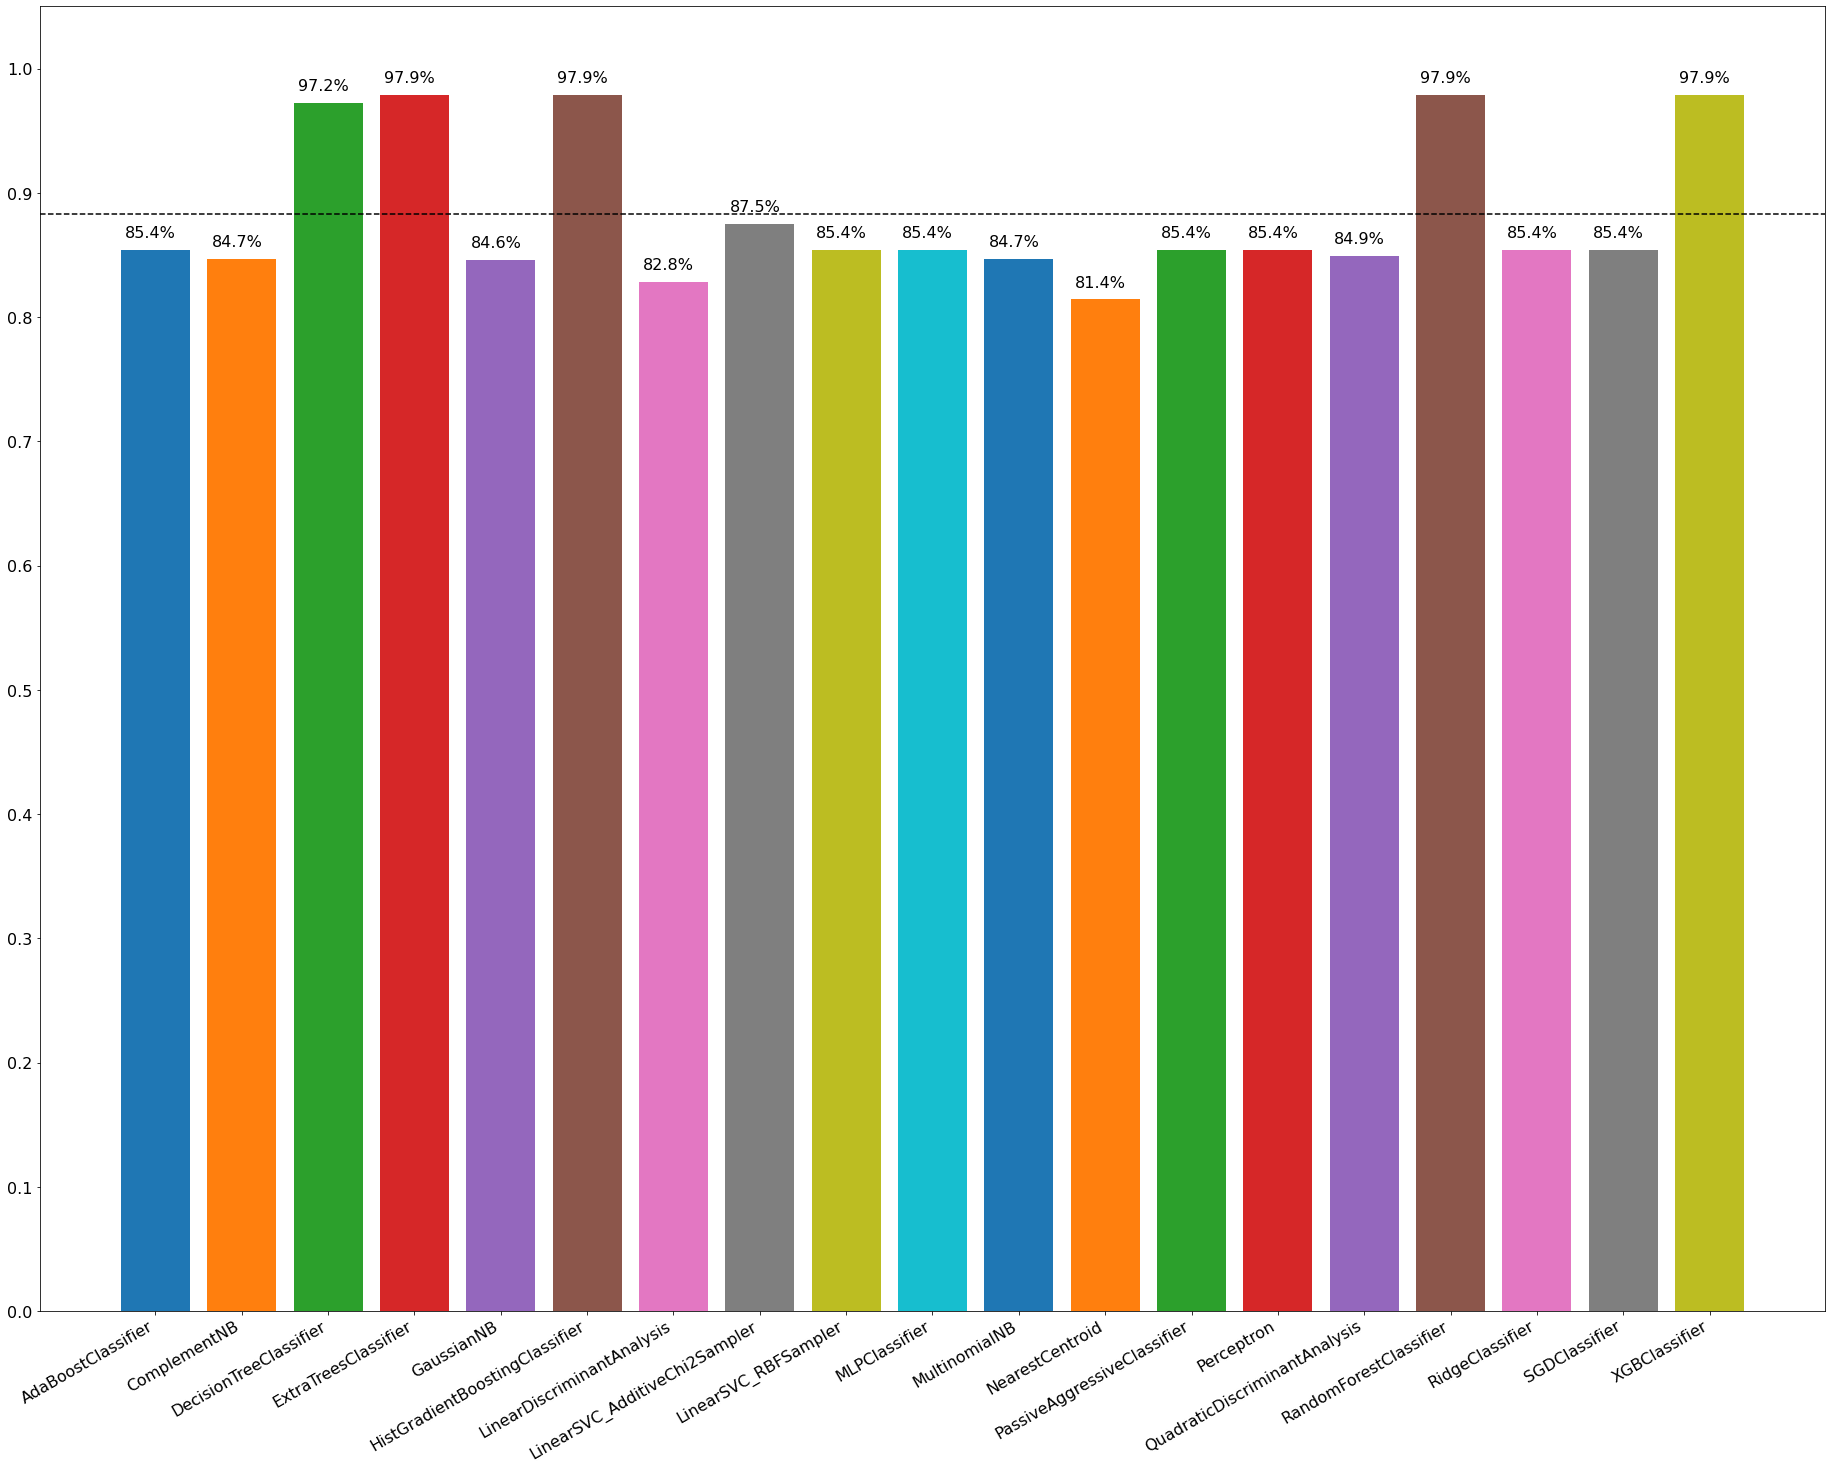

In [12]:
plt.figure(figsize=(32,24))
plt.rcParams['font.size'] = '16'
idx = 0
for key, value in best_results.items():
    name_i = key
    value_i = best_results[key][0]['report']['weighted avg']['f1-score']
    plt.bar(name_i,value_i)
    plt.text(idx-0.35,value_i+0.01,f'{100*value_i:.1f}%')
    idx += 1
mean = np.mean([best_results[k][0]['report']['weighted avg']['f1-score'] for k,v in best_results.items()])
plt.axhline(mean, color='black', linestyle='--')
plt.xticks(rotation=30, ha='right')
plt.xticks(range(0,len(best_results)),best_results.keys())
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1.05)
plt.savefig(f'sequential_{uuid}.png')
plt.show(block=False)

In [13]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-03-11 01:14:31.
